# Generating Rest Frame SEDs from a Parametric Galaxy

Building on the `make_sfzh` documents we can now see how to generate a galaxy and produce its rest-frame spectral energy distribution.


In [94]:
import os
import numpy as np
import matplotlib.pyplot as plt
from synthesizer.filters import FilterCollection
from synthesizer.grid import Grid
from synthesizer.parametric.sfzh import SFH, ZH, generate_sfzh
from synthesizer.parametric.galaxy import Galaxy
from synthesizer.plt import single, single_histxy, mlabel
from unyt import yr, Myr
from astropy.cosmology import Planck18 as cosmo

We begin by initialising a `Grid`:

In [95]:
grid_name = "test_grid"
grid_dir = "../../../tests/test_grid/"
grid = Grid(grid_name, grid_dir=grid_dir)

Next we can define the star formation and metal enrichment history:

In [96]:
# define the parameters of the star formation and metal enrichment histories
sfh_p = {'duration': 10 * Myr}
Z_p = {'log10Z': -2.0}  # can also use linear metallicity e.g. {'Z': 0.01}
stellar_mass = 1E8 # in units of M_sol

# define the functional form of the star formation and metal enrichment histories
sfh = SFH.Constant(sfh_p)  # constant star formation
print(sfh)  # print sfh summary
Zh = ZH.deltaConstant(Z_p)  # constant metallicity

# get the 2D star formation and metal enrichment history for the given SPS grid. This is (age, Z).
sfzh = generate_sfzh(grid.log10age, grid.metallicity, sfh, Zh, stellar_mass=stellar_mass)
print(sfzh)

----------
SUMMARY OF PARAMETERISED STAR FORMATION HISTORY
<class 'synthesizer.parametric.sfzh.SFH.Constant'>
duration: 10 Myr
median age: 5.00 Myr
mean age: 5.00 Myr
----------

----------
SUMMARY OF BINNED SFZH
median age: 5.01 Myr
mean age: 5.05 Myr
mean metallicity: 0.0100
----------



Create a `Galaxy` object using this SZFH:

In [97]:
galaxy = Galaxy(sfzh)

When combined with a `Grid` we can now generate the spectral energy distribution of a galaxy. There are a range of options available to us here, most depending on whether we include nebular emission and/or dust.

Let's star with just the pure stellar spectra. As you can see there is also a method on `Galaxy` objects that allows us to quickly plot spectra.

(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='$\\rm log_{10}(\\lambda/\\AA)$', ylabel='$\\rm log_{10}(L_{\\nu}/erg\\ s^{-1}\\ Hz^{-1} M_{\\odot}^{-1})$'>)

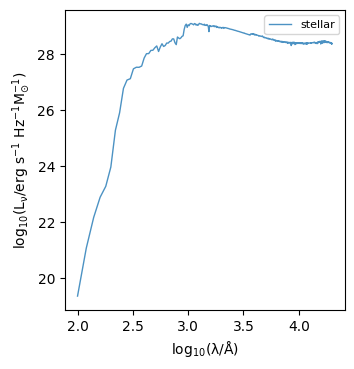

In [98]:
galaxy.get_spectra_stellar(grid)
galaxy.plot_spectra()

However, in most cases we might like to access spectra directly. Spectra are stored within each `Galaxy` in the `spectra` dictionary.

In [99]:
sed = galaxy.spectra['stellar']

Spectra are stored in `Sed` objects. There is a separate tutorial on these but the contain the spectra, wavelength grid, and have access to a range of other methods, e.g. for caclulating broadband photometry.

In [100]:

print(sed)

----------
SUMMARY OF SED 
Number of wavelength points: 995 
----------


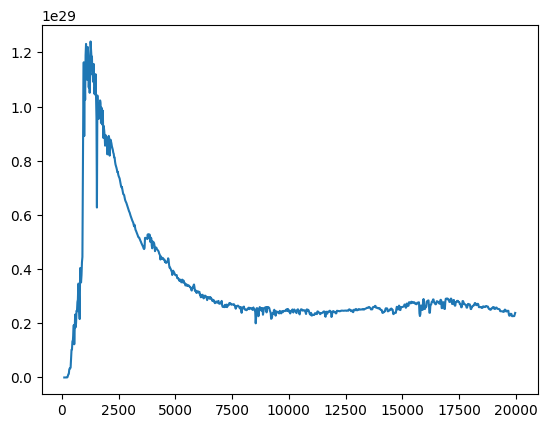

In [101]:
plt.plot(sed.lam, sed.lnu)
plt.show()

Next, we can generate spectra including nebular emission. In the parlance of `synthesizer` these are intrinsic spectra. This introduces a new free parameter, the Lyman-continuum escape fraction, `fesc`.

(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='$\\rm log_{10}(\\lambda/\\AA)$', ylabel='$\\rm log_{10}(L_{\\nu}/erg\\ s^{-1}\\ Hz^{-1} M_{\\odot}^{-1})$'>)

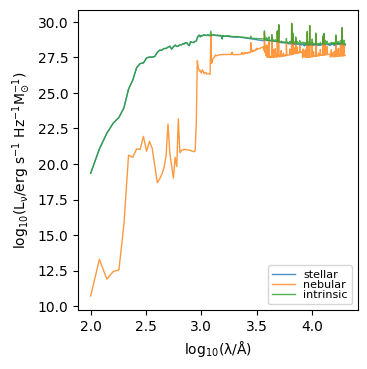

In [102]:
galaxy.get_spectra_intrinsic(grid, fesc = 0.5)
galaxy.plot_spectra()

Note how the `plot_spectra` method plots all the available spectra.

In [103]:
print(galaxy.spectra.keys())

dict_keys(['stellar', 'nebular', 'intrinsic'])


Next let's include dust attenuation using a simple screen. This method also implicitly includes nebular emission. The required free parameter here is `tauV` the attenuation at 5500A. It is also possible to define the dust curve here. There is a separate tutorial on dust attenuation.

*Add tutorial on dust curves*

(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='$\\rm log_{10}(\\lambda/\\AA)$', ylabel='$\\rm log_{10}(L_{\\nu}/erg\\ s^{-1}\\ Hz^{-1} M_{\\odot}^{-1})$'>)

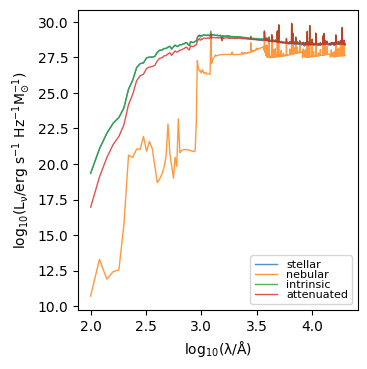

In [104]:
galaxy.get_spectra_screen(grid, tauV = 0.1, fesc = 0.5)
galaxy.plot_spectra()

`synthesizer` also includes an implementation of the Charlot and Fall (2000) two component dust model.

(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='$\\rm log_{10}(\\lambda/\\AA)$', ylabel='$\\rm log_{10}(L_{\\nu}/erg\\ s^{-1}\\ Hz^{-1} M_{\\odot}^{-1})$'>)

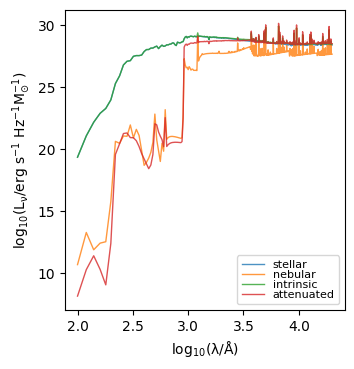

In [105]:
galaxy.get_spectra_CharlotFall(grid, tauV_ISM=0.1, tauV_BC=0.1, alpha_ISM=-0.7, alpha_BC=-1.3)
galaxy.plot_spectra()

`synthesizer`'s most flexible dust model though is the Pacman model. In this model the parameter `fesc` denotes the fraction of light that entirely escapes a galaxy with no reprocessing by gas or dust.

/Users/sw376/Dropbox/Research/projects/synthesizer/venv/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='$\\rm log_{10}(\\lambda/\\AA)$', ylabel='$\\rm log_{10}(L_{\\nu}/erg\\ s^{-1}\\ Hz^{-1} M_{\\odot}^{-1})$'>)

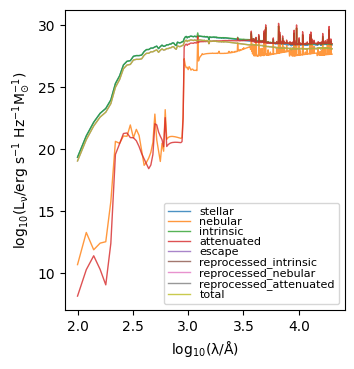

In [106]:
galaxy.get_spectra_pacman(grid, tauV = 0.1, fesc = 0.5)
galaxy.plot_spectra()

The Pacman model also includes an additional free parameter which encodes the Lyman-alpha escape fraction.

(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='$\\rm log_{10}(\\lambda/\\AA)$', ylabel='$\\rm log_{10}(L_{\\nu}/erg\\ s^{-1}\\ Hz^{-1} M_{\\odot}^{-1})$'>)

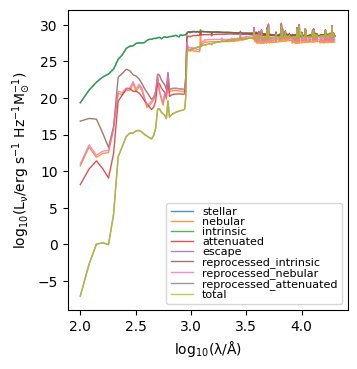

In [107]:
galaxy.get_spectra_pacman(grid, fesc = 0.0, fesc_LyA = 0.0)
galaxy.plot_spectra()

Showing a different `tauV`:

(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='$\\rm log_{10}(\\lambda/\\AA)$', ylabel='$\\rm log_{10}(L_{\\nu}/erg\\ s^{-1}\\ Hz^{-1} M_{\\odot}^{-1})$'>)

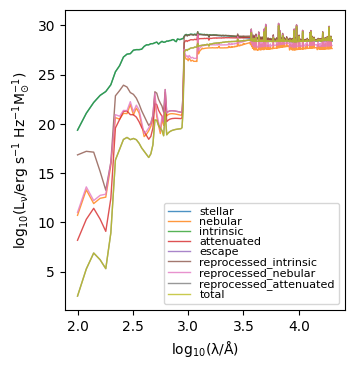

In [108]:
galaxy.get_spectra_pacman(grid, fesc=0.0, fesc_LyA=0.5, tauV=0.6)
galaxy.plot_spectra()

The CF00 model can be recovered using the Pacman implementation:

(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='$\\rm log_{10}(\\lambda/\\AA)$', ylabel='$\\rm log_{10}(L_{\\nu}/erg\\ s^{-1}\\ Hz^{-1} M_{\\odot}^{-1})$'>)

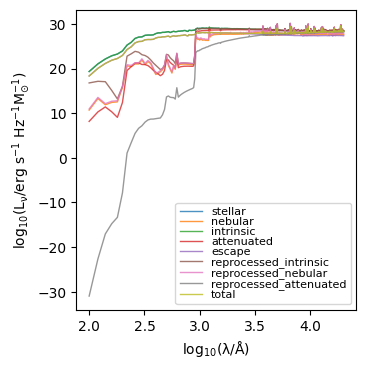

In [109]:
galaxy.get_spectra_pacman(grid, fesc = 0.1, fesc_LyA = 0.1, tauV=[1.,1.], alpha = [-1,-1], CF00=True)
galaxy.plot_spectra()

Like other objects in `synthesizer` we can also get a useful summary of the `Galaxy` object just using the `print` function:

In [110]:
print(galaxy)

----------
SUMMARY OF PARAMETRIC GALAXY
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣀⣀⡀⠒⠒⠦⣄⡀⠀⠀⠀⠀⠀⠀⠀
        ⠀⠀⠀⠀⠀⢀⣤⣶⡾⠿⠿⠿⠿⣿⣿⣶⣦⣄⠙⠷⣤⡀⠀⠀⠀⠀
        ⠀⠀⠀⣠⡾⠛⠉⠀⠀⠀⠀⠀⠀⠀⠈⠙⠻⣿⣷⣄⠘⢿⡄⠀⠀⠀
        ⠀⢀⡾⠋⠀⠀⠀⠀⠀⠀⠀⠀⠐⠂⠠⢄⡀⠈⢿⣿⣧⠈⢿⡄⠀⠀
        ⢀⠏⠀⠀⠀⢀⠄⣀⣴⣾⠿⠛⠛⠛⠷⣦⡙⢦⠀⢻⣿⡆⠘⡇⠀⠀
        ---+-+-+-+-+-+-+-+-+-+-+-+---
           |S|Y|N|T|H|E|S|I|Z|E|R|
        ---+-+-+-+-+-+-+-+-+-+-+-+---
        ⠀⠀⢸⡇⠸⣿⣷⠀⢳⡈⢿⣦⣀⣀⣀⣠⣴⣾⠟⠁⠀⠀⠀⠀⢀⡎
        ⠀⠀⠘⣷⠀⢻⣿⣧⠀⠙⠢⠌⢉⣛⠛⠋⠉⠀⠀⠀⠀⠀⠀⣠⠎⠀
        ⠀⠀⠀⠹⣧⡀⠻⣿⣷⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣠⡾⠃⠀⠀
        ⠀⠀⠀⠀⠈⠻⣤⡈⠻⢿⣿⣷⣦⣤⣤⣤⣤⣤⣴⡾⠛⠉⠀⠀⠀⠀
        ⠀⠀⠀⠀⠀⠀⠈⠙⠶⢤⣈⣉⠛⠛⠛⠛⠋⠉⠀⠀⠀⠀⠀⠀⠀⠀
        ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠉⠉⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
<class 'synthesizer.parametric.galaxy.Galaxy'>
log10(stellar mass formed/Msol): 8.0
available SEDs: ['stellar', 'nebular', 'intrinsic', 'attenuated', 'escape', 'reprocessed_intrinsic', 'reprocessed_nebular', 'reprocessed_attenuated', 'total']
available lines: []
available images: []
----------



We can also extract an spectra and generate broadband photometry. See the `Sed` and `Filter` tutorials:

In [111]:

sed = galaxy.spectra['total']

tophats = {'U': {'lam_eff': 3650, 'lam_fwhm': 660},
           'V': {'lam_eff': 5510, 'lam_fwhm': 880},
           'J': {'lam_eff': 12200, 'lam_fwhm': 2130}}
fc = FilterCollection(tophat_dict=tophats, new_lam=grid.lam)
bb_lnu = sed.get_broadband_luminosities(fc)
print(bb_lnu)

{'U': unyt_quantity(9.13536853e+27, 'erg/(Hz*s)'), 'V': unyt_quantity(8.82988111e+27, 'erg/(Hz*s)'), 'J': unyt_quantity(1.82604528e+28, 'erg/(Hz*s)')}
